* Author: Mingfeng Liu(NNU)
* E-mail: phylmf@njnu.edu.cn

# Introduction
* In this tutorial, we will introduce the basic usage of pPXF in fitting the SDSS spectrum;
* The information about the example galaxy can be found via: 
* https://skyserver.sdss.org/dr18/VisualTools/quickobj?sId=2042394327182764032

# Preparation:
* Open a terminal (Crtl + Alt + T)
* Install pPXF via: "pip install ppxf"
* Wait for complete installation 

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import ppxf.ppxf_util as util
import ppxf.miles_util as lib

from time import perf_counter as clock
from os import path
from astropy.io import fits
from ppxf.ppxf import ppxf
from scipy import ndimage

In [2]:
# Read the FITS data and show the HDU infomation of the file
spec_file = '/home/phylmf/Code/idl_ppxf_run/spec-1814-54555-0043.fits'
spec_hdu = fits.open(spec_file)
spec_hdu.info()

Filename: /home/phylmf/Code/idl_ppxf_run/spec-1814-54555-0043.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     147   ()      
  1  COADD         1 BinTableHDU     26   3825R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


In [3]:
# From the above output, we can see that the HDU with index = 1 is the spectrum data we need

# load the SDSS spectrum

gal_spec = spec_hdu[1].data     

# get the inferred spectroscopic redshift by SDSS team
# there is conflicts in z value between the FITS file and SDSS website
# for consistence with our IDL version tutorial, we apply the former one value 

gal_z = float(spec_hdu[2].data['Z'])       

# load the wavelength data, please convert it from 'log' to 'linear' and turn it into rest-frame before next step                                                         

wave = 10 ** gal_spec['loglam'] / (1 + gal_z)

# convert the vacumm wavelength into air wavelength
# (reasons can be found in SDSS website; in this tutorial, we apply MILES spectal library(wavelength), thus a conversion is needed)

wave *= np.median(util.vac_to_air(wave) / wave)

# mask the data with the givenwavelength range

mask = (wave > 3650) & (wave < 7400)

flux = gal_spec['flux']
flux = flux[mask]

ivar = gal_spec['ivar']
ivar = ivar[mask]

wave = wave[mask]

# Normalization of the spectrum
# If we multiply the fitting spectrum with 'scale'
# it will recover the original scale

scale = np.median(flux)

galaxy = flux / scale

# compute the flux_err(noise) for spectrum

noise = ivar ** (- 0.5) / scale

In [4]:
c = 299792.458                          # speed of light in km/s
velscale = c * np.log(wave[1] / wave[0])# eq. (8) of Cappellari (2017)
FWHM_gal = 2.76                         # SDSS has an approximate instrumental resolution FWHM of 2.76A.

# Next step is to generate the gas and stellar templates for pPXF fitting

In [5]:
# Define the function as described in our IDL tutorial:

def setup_spectral_library(velscale, FWHM_gal):

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis et al. (2010, MNRAS, 404, 1639) http://miles.iac.es/.
    #
    # For this example I downloaded from the above website a set of
    # model spectra with default linear sampling of 0.9A/pix and default
    # spectral resolution of FWHM=2.51A. I selected a Salpeter IMF
    # (slope 1.30) and a range of population parameters:
    #
    #     [M/H] = [-1.71, -1.31, -0.71, -0.40, 0.00, 0.22]
    #     Age = range(1.0, 17.7828, 26, /LOG)
    #
    # This leads to a set of 156 model spectra with the file names like
    #
    #     Mbi1.30Z*.fits
    #
    # IMPORTANT: the selected models form a rectangular grid in [M/H]
    # and Age: for each Age the spectra sample the same set of [M/H].
    #
    # We assume below that the model spectra have been placed in the
    # directory "miles_models" under the current directory.
    #
    
    model_dir = '/home/phylmf/Code/idl_ppxf_run/lib/ppxf/model/'
    model_spec = 'Mbi1.30Z*.fits'
    
    vazdekis = glob.glob(model_dir + model_spec)
    vazdekis.sort()
    
    FWHM_tem = 2.51 # Vazdekis+10 spectra have a resolution FWHM of 2.51A.

    # Extract the wavelength range and logarithmically rebin one spectrum
    # to the same velocity scale of the SDSS galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lamRange_temp = h2['CRVAL1'] + np.array([0.,h2['CDELT1']*(h2['NAXIS1']-1)])
    sspNew, logLam_temp, velscale = util.log_rebin(lamRange_temp, ssp, velscale=velscale)

    # Create a three dimensional array to store the
    # two dimensional grid of model spectra
    #
    
    nAges = 53
    nMetal = 12
    templates = np.empty((sspNew.size,nAges,nMetal))

    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    
    FWHM_dif = np.sqrt(FWHM_gal ** 2 - FWHM_tem ** 2)
    sigma = FWHM_dif / 2.355 / h2['CDELT1'] # Sigma difference in pixels

    # Here we make sure the spectra are sorted in both [M/H]
    # and Age along the two axes of the rectangular grid of templates.
    # A simple alphabetical ordering of Vazdekis's naming convention
    # does not sort the files by [M/H], so we do it explicitly below
    #
    
    metal = ['Zm0.25', 'Zm0.35', 'Zm0.66', 'Zm0.96', 'Zm1.26', 'Zm1.49', 'Zm1.79', 'Zm2.27', 'Zp0.06', 'Zp0.15', 'Zp0.26', 'Zp0.40']
    
    for k, mh in enumerate(metal):
        files = [s for s in vazdekis if mh in s]
        for j, filename in enumerate(files):
            hdu = fits.open(filename)
            ssp = hdu[0].data
            ssp = ndimage.gaussian_filter1d(ssp,sigma)
            sspNew, logLam2, velscale = util.log_rebin(lamRange_temp, ssp, velscale = velscale)
            templates[:,j,k] = sspNew # Templates are *not* normalized here

    return templates, lamRange_temp, logLam_temp

In [6]:
stars_templates, lamRange_temp, logLam_temp = setup_spectral_library(velscale, FWHM_gal)

# The stellar templates are reshaped into a 2-dim array with each spectrum
# as a column, however we save the original array dimensions, which are
# needed to specify the regularization dimensions
    
reg_dim = stars_templates.shape[1:]
stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)

# See the pPXF documentation for the keyword REGUL,
# for an explanation of the following two lines

stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
regul_err = 0.004 # Desired regularization error

# Construct a set of Gaussian emission line templates.
# Estimate the wavelength fitted range in the rest frame.

lamRange_gal = np.array([np.min(wave), np.max(wave)])

gas_templates, line_names, line_wave = util.emission_lines(logLam_temp, lamRange_gal, FWHM_gal)

# Combines the stellar and gaseous templates into a single array
# during the PPXF fit they will be assigned a different kinematic
# COMPONENT value

templates = np.hstack([stars_templates, gas_templates])

Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726'
 '[OII]3729' '[SII]6716' '[SII]6731' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


# Start Fitting

In [64]:
# Setup initial guess of the fitting 
c = 299792.458 # km/s
dv = (np.log(lamRange_temp[0]) - np.log(wave[0])) * c # km/s
vel = 0

# for local universe, if the redshift is low, a inital test value of c * gal_z is also reasonable

# Here the actual fit starts. The best fit is plotted on the screen.
#
# IMPORTANT: Ideally one would like not to use any polynomial in the fit
# as the continuum shape contains important information on the population.
# Unfortunately this is often not feasible, due to small calibration
# uncertainties in the spectral shape. To avoid affecting the line strength of
# the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
# multiplicative ones (MDEGREE=10). This is only recommended for population, not
# for kinematic extraction, where additive polynomials are always recommended.
#

start = [vel, 140.] # (km/s), starting guess for [V,sigma]

t = clock()

# Assign component=0 to the stellar templates and
# component=1 to the gas emission lines templates.
# One can easily assign different kinematic components to different gas species
# e.g. component=1 for the Balmer series, component=2 for the [OIII] doublet, ...)
# Input a negative MOMENTS value to keep fixed the LOSVD of a component.
#

nTemps = stars_templates.shape[1]
nLines = gas_templates.shape[1]
component = [0] * nTemps + [1] * nLines
moments = [4, 2] # fit (V,sig,h3,h4) for the stars and (V,sig) for the gas
start = [start, start] # adopt the same starting value for both gas and stars

pp = ppxf(templates, galaxy, noise, velscale, start, 
          plot = False, moments = moments, degree = -1, mdegree = 10, 
          vsyst = dv, clean = False, regul = 1./regul_err, 
          reg_dim = reg_dim, component = component)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:        77       260     0.009    -0.004
 comp.  1:       195       290
chi2/DOF: 0.9888; DOF: 3053; degree = -1; mdegree = 10
method = capfit; Jac calls: 11; Func calls: 191; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 42/655


Desired Delta Chi^2: 78.35
Current Delta Chi^2: -34.3
Elapsed time in PPXF: 74.51 s
++++++++++++++++++++++++++++++
Gas V=195 and sigma=2.9e+02 km/s
Emission lines peak intensity:
         H10: 0.941
          H9: 0
          H8: 1.52
        Heps: 1.04
      Hdelta: 0.937
      Hgamma: 0.886
       Hbeta: 1.6
      Halpha: 5.64
   [OII]3726: 7.68
   [OII]3729: 0
   [SII]6716: 2.82
   [SII]6731: 1.35
 [NeIII]3968: 0
 [NeIII]3869: 0.509
    HeII4687: 0.817
     HeI5876: 0.0635
[OIII]5007_d: 3.82
  [OI]6300_d: 0.68
 [NII]6583_d: 7
------------------------------


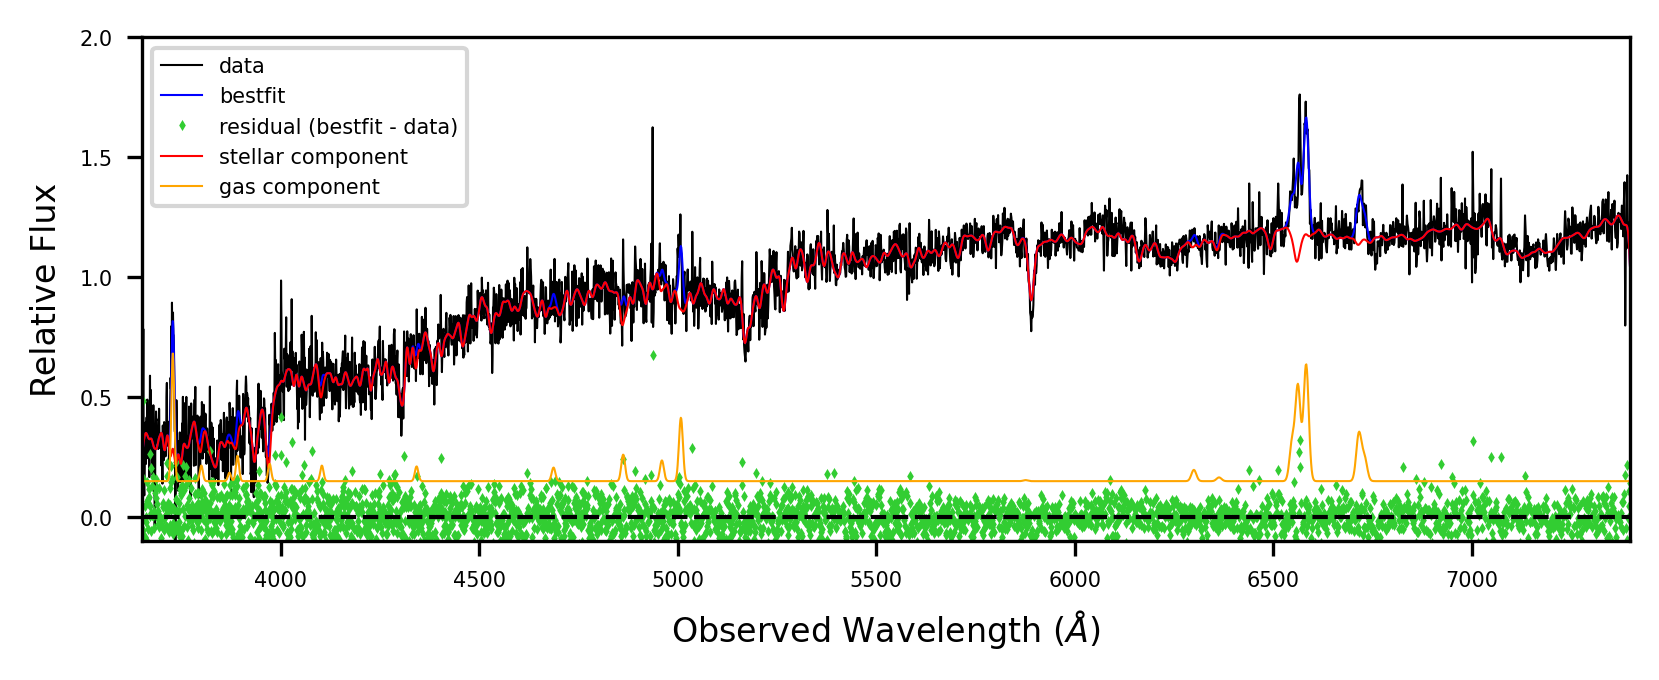

In [67]:
# Plot fit results for stars and gas

plt.figure(dpi = 300)
plt.clf()
plt.subplot(211)
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.plot(wave, pp.galaxy, 'k', linewidth = 0.5, label = 'data')
plt.plot(wave, pp.bestfit, 'b', linewidth = 0.5, label = 'bestfit')
plt.xlabel("Observed Wavelength ($\AA$)", fontsize = 8)
plt.ylabel("Relative Flux", fontsize = 8)
plt.ylim([-0.1, 2])
plt.xlim([np.min(wave), np.max(wave)])
#plt.xlim(6500, 6600)
plt.plot(wave, pp.galaxy - pp.bestfit, 'd', ms = 0.5, 
         color = 'LimeGreen', 
         mec = 'LimeGreen', 
         label = 'residual (bestfit - data)') # fit residuals
plt.axhline(y = -0, linestyle = '--', color = 'k', linewidth = 1)
stars = pp.matrix[:,:nTemps].dot(pp.weights[:nTemps])
plt.plot(wave, stars, 'r', linewidth = 0.5, label = 'stellar component') # overplot stellar templates alone
gas = pp.matrix[:,-nLines:].dot(pp.weights[-nLines:])
plt.plot(wave, gas + 0.15, 'orange', linewidth = 0.5, label = 'gas component') # overplot emission lines alone
plt.legend(fontsize = 5)

# When the two Delta Chi^2 below are the same, the solution is the smoothest
# consistent with the observed spectrum.
#

print('Desired Delta Chi^2: %.4g' % np.sqrt(2 * galaxy.size))
print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1) * galaxy.size))
print('Elapsed time in PPXF: %.2f s' % (clock() - t))

w = np.where(np.array(component) == 1)[0] # Extract weights of gas emissions
print('++++++++++++++++++++++++++++++')
print('Gas V=%.4g and sigma=%.2g km/s' % (pp.sol[1][0], pp.sol[1][1]))
print('Emission lines peak intensity:')
for name, weight, line in zip(line_names, pp.weights[w], pp.matrix[:,w].T):
    print('%12s: %.3g' % (name, weight * np.max(line) * scale / temp_scale))
print('------------------------------')

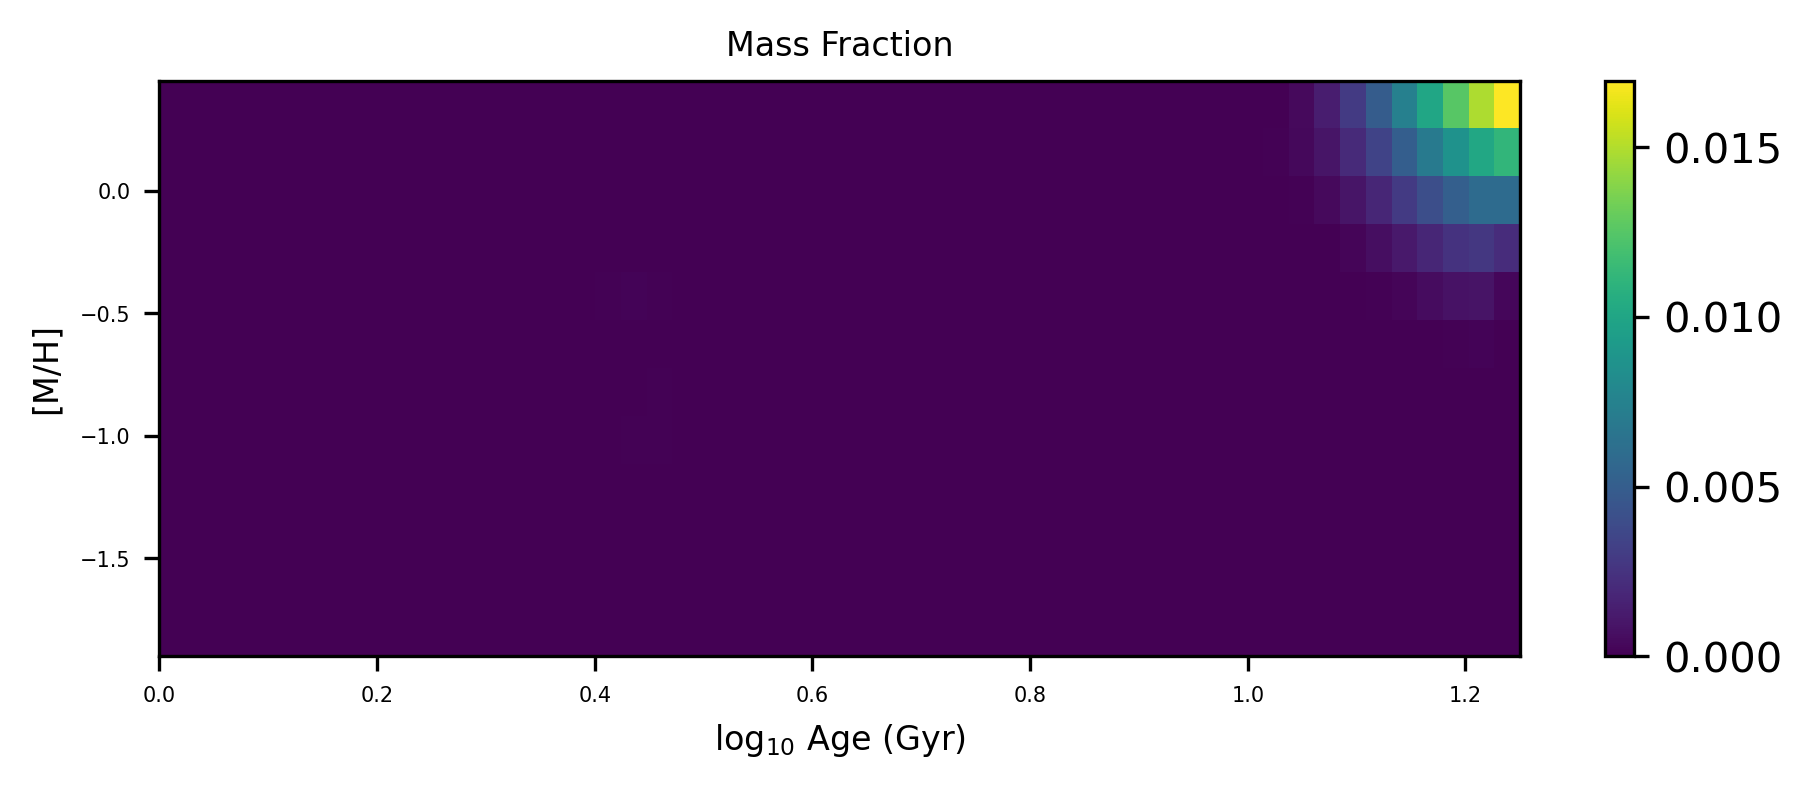

In [68]:
# Plot stellar population mass distribution
plt.figure(dpi = 300)
plt.subplot(212)
weights = pp.weights[:np.prod(reg_dim)].reshape(reg_dim) / pp.weights.sum()
plt.imshow(np.rot90(weights), interpolation = 'nearest', 
           cmap = 'viridis', aspect = 'auto', origin = 'upper', 
           extent = (np.log10(1.0), np.log10(17.7828), -1.9, 0.45))
plt.colorbar()
plt.title("Mass Fraction", fontsize = 8)
plt.xlabel("log$_{10}$ Age (Gyr)", fontsize = 8)
plt.ylabel("[M/H]", fontsize = 8)
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.show()

# Calculate the total stellar mass
* (see Chap 1.10 in Xueguang Zhang's book of galaxy astrophysics)
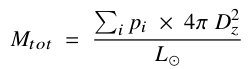

In [69]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# Define a Flat-LambdaCDM cosmology model to compute the luminosity distance

cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)

In [70]:
Dz = cosmo.luminosity_distance(z = gal_z)  
Dz

# Convert to cm

Dz = Dz.to(u.cm)

In [71]:
from astropy.constants import iau2015 as const

# get solar luminosity value
L_sol = const.L_sun
# Convert to erg/s
L_sol = L_sol.to(u.erg / u.s)

# the normalization scale of the SSP stellar component templates
temp_scale = np.median(stars_templates)

# The contribution of stellar component from SSP
# we need to multiply the weights of stellar component to 
comp_list = pp.component
weights_list = pp.weights
stellar_comp_mask = (comp_list == 0)
total_flux_ssp = templates * weights_list
stellar_flux = total_flux_ssp[:, stellar_comp_mask]

# the final results
M_tot = np.log10(stellar_flux.sum() * scale / temp_scale * 4 * np.pi * (Dz.value ** 2) / L_sol.value * (10 ** -17))
print('The total stellar mass is:', M_tot, 'dex', u.solMass)

The total stellar mass is: 9.66344487614962 dex solMass


# Calculate median age and median metallicity

In [72]:
# list the templates' age and metallicity value:

ages = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 
        0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
        0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 
        2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 
        4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 
        7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 
        11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0]

metal = [-2.27, -1.79, -1.49, -1.26, -0.96, -0.66, 
         -0.35, -0.25, 0.06, 0.15, 0.26, 0.40]

In [73]:
ages_list = []
for i in range(len(metal)):
    ages_list += ages
ages_list = np.array(ages_list)

metal_list = []
for i in range(len(ages)):
    metal_list += metal
metal_list = np.array(metal_list)

stellar_weights = weights_list[:nTemps]

non_0_mask = (stellar_weights != 0)

non_0_stellar_weights = stellar_weights[non_0_mask]

non_0_ages_list = ages_list[non_0_mask]

non_0_metal_list = metal_list[non_0_mask]

med_age = sum(non_0_ages_list * non_0_stellar_weights) / non_0_stellar_weights.sum()

med_metal = sum(non_0_metal_list * non_0_stellar_weights) / non_0_stellar_weights.sum()

print("median age is: ", med_age, 'Gyr')
print("median metallicity is: ", med_metal)

median age is:  6.100435209484507 Gyr
median metallicity is:  0.27551490891520364


# Calculate the SFR (Star Formation Rate)
* 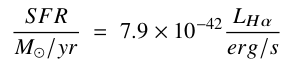
* 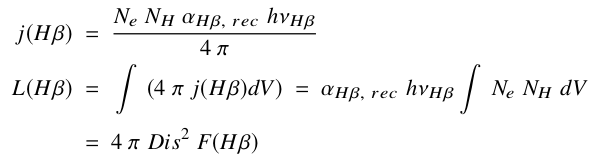

In [75]:
from scipy.integrate import simps

h_alpha_wavelength_range = (6550, 6576)

h_alpha_mask = (wave >= h_alpha_wavelength_range[0]) & (wave <= h_alpha_wavelength_range[1])
h_alpha_wave = wave[h_alpha_mask]
h_alpha_flux = gas[h_alpha_mask]

# H_alpha Flux Calculation
h_alpha_flux_integral = simps(h_alpha_flux, h_alpha_wave)
SFR_val = h_alpha_flux_integral * (10 ** -17) * scale / temp_scale * 4 * np.pi * (Dz.value ** 2) * 7.9 * (10 ** -42)
print("star formation rate is: ", SFR_val, 'M_sol / yr')

star formation rate is:  0.38284104262626967 M_sol / yr


In [77]:
# log(sSFR), and we find that this is a star-forming galaxy

np.log10(SFR_val / 10 ** M_tot)

-10.080426385836269

## : )